# Plot PPSD on the BP network
2021.05.25 Kurama Okubo

This notebook plot PPSD on the BP network to check the consistency in ambient seismic noise strength.

2022.06.22: update to compare with UW backup data.

2023.04.26: update figure colorbar.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns # to plot heatmap
import matplotlib.dates as mdates

import itertools


os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
figdir = "./figure_DataAvailability_BP"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
datacase = "seisremoveeq" #"rawseismicdata" #"seisremoveeq"
csv_file = f"./csv_dataavailability_uw/dataavailability_{datacase}_uw_2002-2022.csv"
datatype = csv_file.split('/')[-1][:-4]
df_origin = pd.read_csv(csv_file)

## Merge channels between ..BP* and .40.SP*

As the instruments are replaced during 2011-12, we combine BP* and SP* as single channel 

In [4]:
def get_sta_nochan(x):
    net, sta, loc, chan = x.split(".")
    return "{}.{}-{}".format(net, sta, chan[-1])

df_origin['sta_nochan'] = df_origin['station'].apply(get_sta_nochan)
stations = df_origin['sta_nochan'].unique()

## convert to datetime

In [5]:
def datestr2date(x):
    return pd.to_datetime(x.split('T')[0], format='%Y-%m-%d')
    
df_origin['plotdate'] = df_origin['date'].apply(datestr2date)

## Plot heatmap

sns.heatmap is a categorical plot, so we cannot use DatetimeLocater. So we first prepare the plotting dateframe with uniform time vector, then prepare xticks and xticklabels independently.

work flow:
1. Initialize dataframe with uniform time vector
2. prepare dataframe for update. Update if seisdata is available using updatekey
3. plot using sns.heatmap. As it is categorical, prepare xticks for yearly locator.

In [6]:
# make uniform time vector
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

download_timeunit = 86400
st_center = (download_timeunit/86400)/2 # mid time of the day
date_range_st = starttime + datetime.timedelta(days=st_center) # day
datefreq = '1D'
uniformdates = pd.date_range(start=date_range_st, end=endtime, freq=datefreq)
uniform_tvec = uniformdates.date
uniform_tvec

array([datetime.date(2002, 1, 1), datetime.date(2002, 1, 2),
       datetime.date(2002, 1, 3), ..., datetime.date(2022, 5, 29),
       datetime.date(2022, 5, 30), datetime.date(2022, 5, 31)],
      dtype=object)

In [7]:
# make new dataframe with uniform tvec; set np.nan if no data is available at that date
stationdate = list(itertools.product(stations, uniform_tvec))
# data_init = [["{}__{}".format(stationdate[i][0], stationdate[i][1]), stationdate[i][0], stationdate[i][1], np.NaN, np.NaN] for i in range(len(stationdate))]
data_init = [["{}__{}".format(stationdate[i][0], stationdate[i][1]), stationdate[i][0], stationdate[i][1], 0.0, 0.0] for i in range(len(stationdate))]

In [8]:
# initialize dataframe
df_dataavail_all = pd.DataFrame(data_init,
                                 columns=['updatekey', 'sta_nochan', 'plotdate_uni', 'data_fraction', 'removal_fraction'])
df_dataavail_all['plotdate_uni'] = pd.to_datetime(df_dataavail_all['plotdate_uni'])
df_dataavail_all.set_index('updatekey', inplace=True)

In [9]:
df_dataavail_all.head()

,sta_nochan,plotdate_uni,data_fraction,removal_fraction
updatekey,,,,
BP.CCRB-1__2002-01-01,BP.CCRB-1,2002-01-01,0.0,0.0
BP.CCRB-1__2002-01-02,BP.CCRB-1,2002-01-02,0.0,0.0
BP.CCRB-1__2002-01-03,BP.CCRB-1,2002-01-03,0.0,0.0
BP.CCRB-1__2002-01-04,BP.CCRB-1,2002-01-04,0.0,0.0
BP.CCRB-1__2002-01-05,BP.CCRB-1,2002-01-05,0.0,0.0


In [10]:
# prepare dataframe for update df
df_temp = df_origin.filter(items=['sta_nochan', 'plotdate', 'data_fraction', 'removal_fraction'])
df_temp.rename(columns = {'plotdate': 'plotdate_uni'}, inplace = True)
df_temp['updatekey'] = df_temp['sta_nochan'].astype(str) + '__' + df_temp['plotdate_uni'].astype(str)
df_temp.set_index('updatekey',inplace=True)

In [11]:
# Manipulate duplication due to instrumental replacement from ..BP* to .40.SP* 
df_temp[df_temp.index.duplicated(keep=False)].head()

,sta_nochan,plotdate_uni,data_fraction,removal_fraction
updatekey,,,,
BP.EADB-1__2011-07-20,BP.EADB-1,2011-07-20,0.962494,0.037500
BP.EADB-2__2011-07-20,BP.EADB-2,2011-07-20,0.929164,0.070833
BP.EADB-3__2011-07-20,BP.EADB-3,2011-07-20,0.952771,0.047223
BP.EADB-1__2011-07-20,BP.EADB-1,2011-07-20,0.997222,0.002778
BP.EADB-2__2011-07-20,BP.EADB-2,2011-07-20,0.997222,0.002778


In [12]:
# Since all overlapped data has a fraction of 1.0, remove one of the rows
df_temp = df_temp.reset_index().drop_duplicates(subset='updatekey').set_index('updatekey')

In [13]:
# update dictionary with the filtered df_origin
df_dataavail_all.update(df_temp)
df_dataavail_all.to_csv('test.csv')

In [14]:
df_plt = df_dataavail_all.pivot(index='sta_nochan', columns='plotdate_uni', values='data_fraction')
df_plt.head()

plotdate_uni,2002-01-01,2002-01-02,2002-01-03,2002-01-04,2002-01-05,2002-01-06,2002-01-07,2002-01-08,2002-01-09,2002-01-10,...,2022-05-22,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27,2022-05-28,2022-05-29,2022-05-30,2022-05-31
sta_nochan,,,,,,,,,,,,,,,,,,,,,
BP.CCRB-1,0.712226,0.868749,0.692331,0.693554,0.677024,0.690726,0.691566,0.834930,0.720818,0.795048,...,0.967122,0.995139,0.996528,0.989583,0.924997,0.993056,0.974305,0.986804,0.996528,0.997900
BP.CCRB-2,0.807991,0.868749,0.835041,0.611987,0.815515,0.860144,0.780380,0.749796,0.841427,0.840671,...,0.971362,0.996528,0.996528,0.997916,0.938884,0.995139,0.972221,0.988194,0.996528,0.996524
BP.CCRB-3,0.816030,0.868749,0.799802,0.832970,0.812727,0.839302,0.791705,0.584377,0.732955,0.810123,...,0.971642,0.995139,0.991667,0.984722,0.959718,0.982637,0.977083,0.991666,0.996528,0.993050
BP.EADB-1,0.947914,0.961109,0.979164,0.939580,0.950690,0.962496,0.982638,0.974998,0.969443,0.954161,...,0.995139,1.000000,1.000000,1.000000,0.940968,0.995832,0.962499,1.000000,1.000000,1.000000
BP.EADB-2,0.988194,0.995832,0.993749,0.982637,0.984027,0.984720,0.988194,0.974997,0.996528,0.991666,...,0.996528,1.000000,0.996528,1.000000,0.963192,0.987499,0.959027,0.993056,0.994444,0.996526


In [15]:
df_plt.columns

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25',
               '2022-05-26', '2022-05-27', '2022-05-28', '2022-05-29',
               '2022-05-30', '2022-05-31'],
              dtype='datetime64[ns]', name='plotdate_uni', length=7456, freq=None)

In [16]:
# manipulate xtick label to plot yearly label
xticks_all = [i + 0.5 for i in range(0, len(df_plt.columns))]
xticks = []
xminorticks = []
xlabels = []
for i, x in enumerate(df_plt.columns):
    # major ticks
    if (x.month == 1) and (x.day == 1):
        xticks.append(xticks_all[i])
        xlabels.append("{}".format(x.year))
        
    # minor ticks
    if (x.month in [1, 4, 7, 10]) and (x.day == 1):
        xminorticks.append(xticks_all[i])


In [17]:
# xminorticks

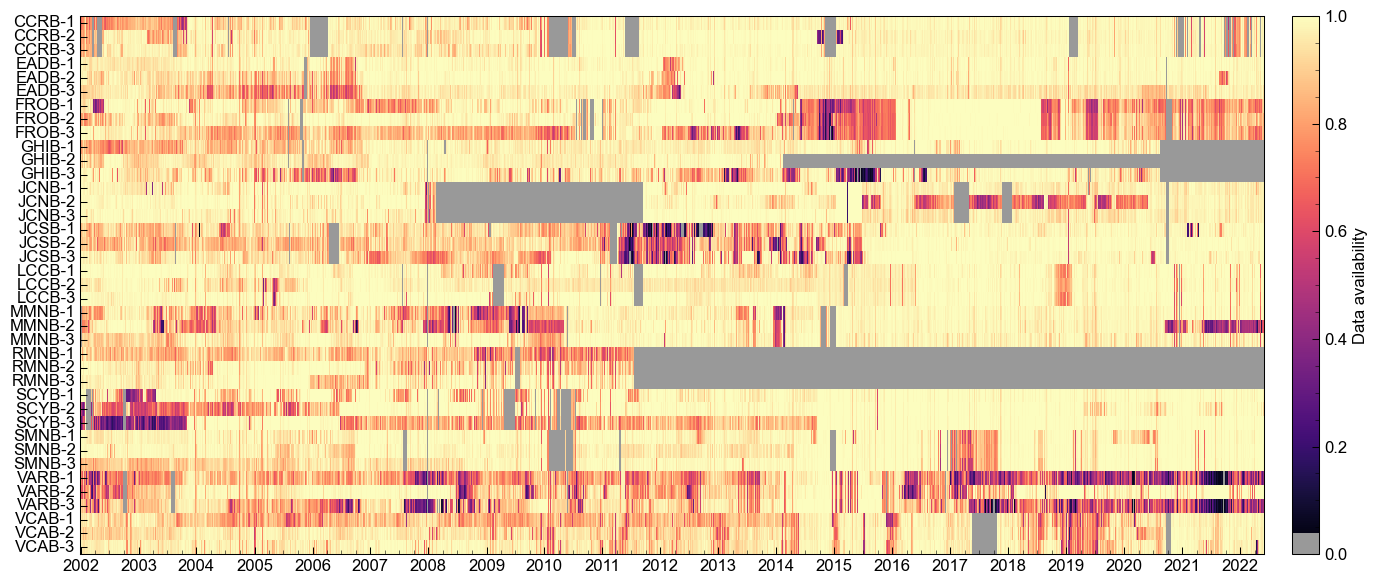

In [18]:
vmin = 0.0
vmax = 1.0

fig, (ax, cax) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios":[1, 0.05]})

cmap1 = sns.color_palette("magma", as_cmap=True)
# manipulate colorpallet so than 0 is in gray
cmap1._lut[0:10] = np.array([ 0.6, 0.6,  0.6,  1.0])

# plot heatmap
h = sns.heatmap(df_plt, linewidth = 0, edgecolor="black", cmap=cmap1, ax=ax, vmin = vmin, vmax=vmax, cbar=False, rasterized=True)

# decorate figure
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xminorticks, minor=True)
ax.set_xticklabels(labels=xlabels, rotation=0, ha='center')

ax.set_yticks(np.linspace(h.axes.get_yticks()[0], h.axes.get_yticks()[-1], len(df_plt)))
ylabels = [x.split(".")[1] for x in df_plt.index]
ax.set_yticklabels(ylabels)

# ax.tick_params(direction="in", width=1.0)
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=False)

# show box outline
for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.tight_layout()

plt.rcParams["ytick.minor.visible"] = True

cax.set_axis_off()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap1), ax=cax, orientation="vertical", fraction=1.3, pad=0.0)
cbar1.set_label('Data availability', color="k")

plt.savefig(figdir+"/DataAvailability_{}.png".format(datacase), format="png", dpi=150)

plt.savefig(figdir+"/DataAvailability_{}.eps".format(datacase), format="eps")


## Compare the data fraction between tacc and uw

In [19]:
csv_file_uw = "./csv_dataavailability_uw/dataavailability_rawseismicdata_uw_2002-2022.csv"
csv_file_tacc = "./csv_dataavailability_tacc/dataavailability_rawseismicdata_tacc.csv"

df_origin_uw = pd.read_csv(csv_file_uw)
df_origin_tacc = pd.read_csv(csv_file_tacc)

In [20]:
df_origin_tacc

,station,date,data_fraction,removal_fraction
0,BP.CCRB..BP1,2002-01-01T11:59:59.5,0.997987,0.0
1,BP.CCRB..BP1,2002-01-02T11:59:59.5,0.999405,0.0
2,BP.CCRB..BP1,2002-01-03T11:59:59.5,0.997642,0.0
3,BP.CCRB..BP1,2002-01-04T11:59:59.5,0.998904,0.0
4,BP.CCRB..BP1,2002-01-05T11:59:59.5,0.999940,0.0
...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0


In [21]:
df_origin_uw['plotdate'] = df_origin_uw['date'].apply(datestr2date)
df_origin_tacc['plotdate'] = df_origin_tacc['date'].apply(datestr2date)

In [22]:
df_origin_tacc

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.5,0.997987,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.5,0.999405,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.5,0.997642,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.5,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.5,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [23]:
# number of data
df_origin_tacc_eq = df_origin_tacc[["station", "plotdate"]]
df_origin_uw_eq = df_origin_uw[["station", "plotdate"]]

In [24]:
# number of data
et_tacc = datetime.datetime(2020, 9, 1)
df_origin_tacc_eq = df_origin_tacc[["station", "plotdate"]].reset_index(drop=True)
df_origin_uw_eq = df_origin_uw[["station", "plotdate"]]
df_origin_uw_eq = df_origin_uw_eq[df_origin_uw_eq["plotdate"] < et_tacc].reset_index(drop=True)

df_origin_uw_trim = df_origin_uw[df_origin_uw["plotdate"] < et_tacc].reset_index(drop=True)


print(f"comparison of data dates: {df_origin_uw_eq.equals(df_origin_tacc_eq)}")

comparison of data dates: True


In [25]:
df_origin_uw_trim

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.500,0.997892,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.500,0.999531,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.500,0.997142,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.500,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.500,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [26]:
df_origin_tacc

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.5,0.997987,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.5,0.999405,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.5,0.997642,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.5,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.5,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [27]:
diff_datafrac = df_origin_tacc["data_fraction"] - df_origin_uw_trim["data_fraction"]

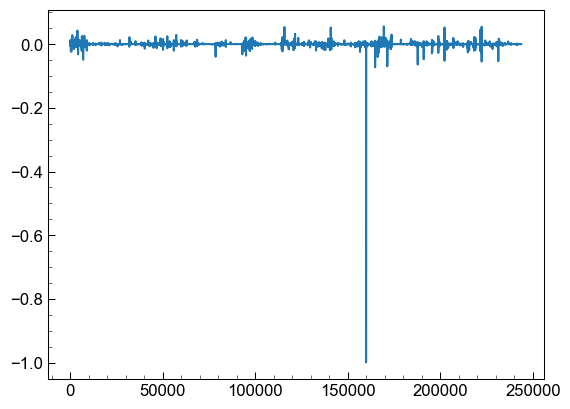

In [28]:
plt.plot(diff_datafrac)
# plt.ylim([-0.1,0.1])
# plt.xlim([0,10000])

In [29]:
np.where(np.abs(diff_datafrac) > 0.5)

(array([159817]),)

NOTE: Only one date containing more data, while the others contains similar amount of data

In [30]:
npts = int(1728000)
Nnullsignal = 10

1 - (float(Nnullsignal)/float(npts))

0.999994212962963

In [31]:
float(npts-Nnullsignal)

1727990.0

In [32]:
np.where(diff_datafrac > 0.02)

(array([  1091,   2950,   3843,   6251,   6291,   7599,  31961,  46019,
         52402,  57230,  94724,  98402, 114639, 115700, 115701, 121449,
        140741, 167028, 168353, 169419, 170313, 173600, 198851, 202206,
        202231, 202241, 218244, 218373, 218869, 221675, 222275, 222287,
        222312]),)

In [33]:
df_origin_tacc.iloc[97028]

station                      BP.JCSB..BP2
date                2002-12-27T11:59:59.5
data_fraction                    0.745072
removal_fraction                      0.0
plotdate              2002-12-27 00:00:00
Name: 97028, dtype: object

In [34]:
df_origin_uw.iloc[97028]

station                  BP.JCNB.40.SP3
date                2012-04-04T12:00:00
data_fraction                       1.0
removal_fraction                    0.0
plotdate            2012-04-04 00:00:00
Name: 97028, dtype: object

# Search data frac for the demonstration of tremor removal

In [35]:
stachan = "BP.EADB-1" # check EADB and 2016-1 contains the contrast in the data contents with and without removal.
df_sta = df_plt.loc[stachan, :]

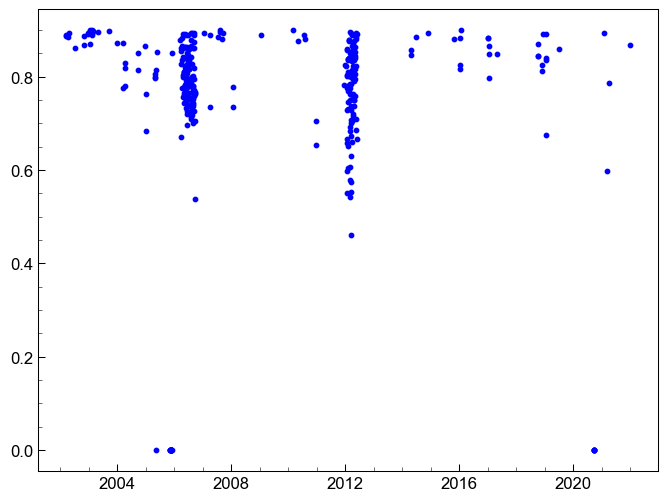

In [36]:
df_filt = df_sta[df_sta < 0.9]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df_filt.index, df_filt.values, 10, "b",)

In [37]:
df_filt[270:320]

plotdate_uni
2012-04-18    0.875683
2012-04-19    0.840267
2012-04-20    0.836793
2012-04-21    0.749285
2012-04-22    0.750682
2012-04-23    0.804848
2012-04-24    0.790266
2012-04-25    0.737397
2012-04-28    0.818740
2012-04-29    0.839572
2012-04-30    0.806238
2012-05-01    0.817355
2012-05-02    0.758324
2012-05-03    0.795831
2012-05-04    0.852770
2012-05-05    0.845129
2012-05-09    0.863876
2012-05-16    0.884719
2012-05-17    0.893748
2012-05-18    0.880552
2012-05-19    0.822913
2012-05-20    0.710409
2012-05-21    0.685310
2012-05-25    0.891662
2012-05-28    0.667349
2014-04-22    0.858333
2014-04-23    0.847250
2014-06-23    0.884718
2014-12-01    0.893053
2015-10-20    0.881702
2016-01-09    0.884024
2016-01-10    0.815969
2016-01-11    0.824298
2016-01-21    0.899998
2017-01-05    0.884025
2017-01-08    0.883328
2017-01-10    0.797910
2017-01-11    0.866664
2017-01-12    0.847907
2017-04-25    0.849734
2018-10-08    0.844089
2018-10-09    0.870164
2018-10-11    0.84358

In [38]:
df_filt[:]

plotdate_uni
2002-03-20    0.886641
2002-03-22    0.890060
2002-04-15    0.885410
2002-04-19    0.893046
2002-07-16    0.862758
                ...   
2020-09-24    0.000000
2021-01-25    0.893049
2021-03-09    0.597905
2021-04-04    0.786802
2021-12-24    0.868748
Name: BP.EADB-1, Length: 330, dtype: float64